# Decision Tree Classifier Model - Morgan Fingerprints

This Notebook will do two things: 

1. Import a CSV file and convert SMILES into Morgan fingerprints
2. Apply those fingerprints as input to train a Decision Tree Classifier

Most of the code was sourced from ChatGPT to kick-start the project. Modifications were applied. 

In [18]:
# Imports 
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef
)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from datetime import datetime

After importing all the necessary libraries, we upload the CSV file with all the data. This file holds 15,619 molecules in the form of SMILES (text). Two additional columns of data provide, the International Chemical Identifier (InChi) and the acitivity (float) of the molecule. 

## Data and Fingerprints

In [2]:
def load_csv(file_path):
    """Function reads a csv file and returns a Panda DataFrame"""
    
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Ensure the file has the necessary columns
    required_columns = {"SMILES", "InChi", "Activity"}
    if not required_columns.issubset(data.columns):
        raise ValueError(f"The input CSV must contain the following columns: {required_columns}")
    data.head()
    
    return data

After uploading the data, we convert the SMILES into fingerprints, leveraging the RDKit library. 

In [3]:
# Convert SMILES to molecular fingerprints
def smiles_to_fingerprint(smiles, radius = 2, nBits = 2048):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
            return np.array(fp)
        else:
            return None
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {e}")
        return None

# Convert Inchi to molecular fingerprints
def inchis_to_fingerprint(inchis, radius = 2, nBits = 2048):
    try:
        mol_inchi = Chem.MolFromInchi(inchis)
        if mol:
            fp_inchi = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits) 
            return np.array(fp_inchi)
        else:
            return None
    except Exception as e:
        print(f"Error processing InChis {inchis}: {e}")
        return None

After creating a set of fingerprints, we then remove any invalid molecules. 

In [4]:
# Remove empty rows
def clean_data(data):
    """Function cleans data (removes negative activities, removes empty cells) and returns X and y"""

    original_size = data["SMILES"].size

    # Remove any missing values
    data = data.dropna(subset=['SMILES'])
    data = data.dropna(subset=['InChi'])
    data = data.dropna(subset=['Activity'])
    data = data.dropna(subset=['ActivityB'])
    data = data.dropna(subset=['Fingerprint'])

    # Check the difference between clean and unclean data
    final_size = data["SMILES"].size
    removed_molecules = original_size-final_size

    # Print values for transparency
    print("")
    print(f"Original Dataset has {original_size} molecules")
    print(f"{removed_molecules} of molecule were removed")
    print(f"Final Size is {final_size}")
    
    return data, removed_molecules

def extract_data(data): 
    """ Function returns Fingerprints and Activity """

    # Define X, y
    X = np.array(data['Fingerprint'].tolist())
    y = data['ActivityB'].values

    return X, y

In [5]:
def binarise_data(data):

    """Function applies a binary classifier to the Activities column"""
    # Binarise 
    # Calculate mean and standard deviation
    mean_activity = data["Activity"].mean()
    std_activity = data["Activity"].std()

    # Convert "activities" column into binary values
    data["ActivityB"] = data["Activity"].apply(
        lambda x: 0 if x > (mean_activity - std_activity) else 1)
    
    return data
    

## Loading and preparing data
Lets train a simple Decision Tree Regressor. 

In [6]:
# Load data
data = load_csv("../Data/training.csv")
testA = load_csv("../Data/test1.csv")
testB = load_csv("../Data/test2.csv")
data.head()

,SMILES,InChi,Activity
0,Cc1nc2ccc(N)cc2s1,InChI=1S/C8H8N2S/c1-5-10-7-3-2-6(9)4-8(7)11-5/...,6.22185
1,Nc1ccc2ncccc2c1,InChI=1S/C9H8N2/c10-8-3-4-9-7(6-8)2-1-5-11-9/h...,4.42091
2,CC(NC(=O)Nc1nnc(C(F)(F)F)s1)(C(F)(F)F)C(F)(F)F,"InChI=1S/C8H5F9N4OS/c1-5(7(12,13)14,8(15,16)17...",5.54683
3,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCCN(CC)CC)c(I)c1,InChI=1S/C25H29I2NO3/c1-4-7-11-22-23(18-10-8-9...,5.49894
4,O=[N+]([O-])c1cc([N+](=O)[O-])c(-c2cc[nH]n2)s1,InChI=1S/C7H4N4O4S/c12-10(13)5-3-6(11(14)15)16...,5.50390


In [7]:
data.describe()

,Activity
count,15618.000000
mean,5.006235
std,0.840051
min,1.872570
25%,4.428867
50%,4.936465
75%,5.508640
max,10.000000


## Clean and Split

In [8]:
# Training Data
data = binarise_data(data)
data['Fingerprint'] = data['SMILES'].apply(smiles_to_fingerprint)
data, mols_train_removed = clean_data(data)


Original Dataset has 15618 molecules
0 of molecule were removed
Final Size is 15618


In [9]:
# Split data
# First split: 80% training, 20% (validation + test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Prep training, test inputs and outputs 
X_train, y_train = extract_data(train_data)
X_test, y_test = extract_data(test_data)

# Check sizes
print("")
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 12494
Testing set size: 3124


## Running the model

In [10]:
# Initialize and train the Decision Tree Classifier
clf = RandomForestClassifier(max_features=5, n_estimators=500)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=5, n_estimators=500)

In [11]:
# Make predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for AUC

In [12]:
sum(y_pred)

207

In [13]:
# Calculate performance metrics
# 1. Precision
precision = precision_score(y_test, y_pred)

# 2. Recall (Sensitivity or True Positive Rate)
recall = recall_score(y_test, y_pred)

# 3. Specificity (True Negative Rate)
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, y_pred).ravel()
specificity = true_neg / (true_neg + false_pos)

# 4. Accuracy
accuracy = accuracy_score(y_test, y_pred)

# 5. F1-score
f1 = f1_score(y_test, y_pred)

# 6. AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_proba)

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 7. MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(y_test, y_pred)

# Print metrics
print("Evaluation Metrics:")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print(f"MCC: {mcc:.3f}")

Evaluation Metrics:
Precision: 0.797
Recall (Sensitivity): 0.343
Specificity: 0.984
Accuracy: 0.885
F1-score: 0.480
AUC: 0.861
MCC: 0.475


In [14]:
# Understanding the balance of the split before training 
counts = data['ActivityB'].value_counts()
print("Before training")
print(f"Inactive molecules : {counts.values[0:1]} out of {len(X_train)}")
print(f"Active molecules : {counts.values[1:2]} out of {len(X_train)}")
active_perc = counts.values[1:2] / len(X_train) * 100
print(f"Active : {active_perc[0]:.2f} percent")

print("")
print("After training")
print(f"Inactive molecules : {y_pred.size - y_pred.sum()} out of {y_pred.size}")
print(f"Active molecules : {y_pred.sum()} out of {y_pred.size}")
active_perc = y_pred.sum() / y_pred.size * 100
print(f"Active : {active_perc:.2f} percent")

Before training
Inactive molecules : [13222] out of 12494
Active molecules : [2396] out of 12494
Active : 19.18 percent

After training
Inactive molecules : 2917 out of 3124
Active molecules : 207 out of 3124
Active : 6.63 percent


## Validation

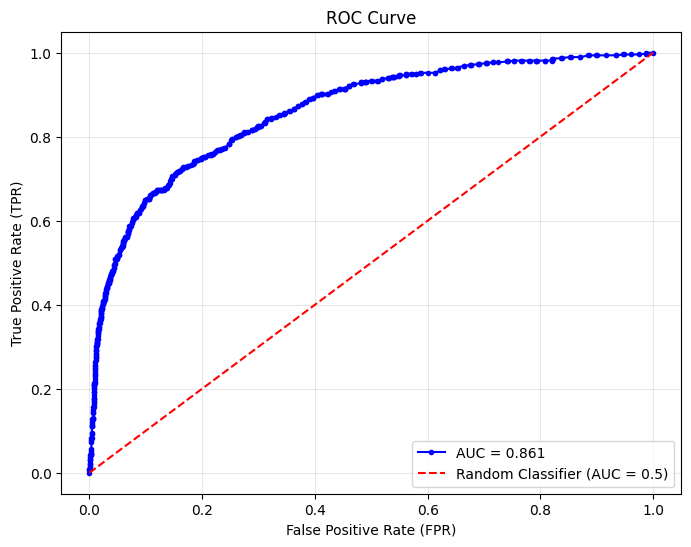

In [24]:
# Calculate FPR, TPR, and thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker = ".", color='blue', label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Save file
import time
file_name = "plots/" + str(time.time()) + ".png"
plt.savefig(file_name)

plt.show()


## Testing
Compare the test and validation set to the model. 

In [29]:
# Calling Test Set B
test = binarise_data(testA)
test['Fingerprint'] = test['SMILES'].apply(smiles_to_fingerprint)
test, mols_test_removed = clean_data(test)


Original Dataset has 258 molecules
0 of molecule were removed
Final Size is 258


In [30]:
# Make predictions
X_test, y_test = extract_data(test)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for AUC

In [31]:
# Calculate performance metrics
# 1. Precision
precision = precision_score(y_test, y_pred)

# 2. Recall (Sensitivity or True Positive Rate)
recall = recall_score(y_test, y_pred)

# 3. Specificity (True Negative Rate)
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, y_pred).ravel()
specificity = true_neg / (true_neg + false_pos)

# 4. Accuracy
accuracy = accuracy_score(y_test, y_pred)

# 5. F1-score
f1 = f1_score(y_test, y_pred)

# 6. AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_proba)

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 7. MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(y_test, y_pred)

# Print metrics
print("Evaluation Metrics:")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print(f"MCC: {mcc:.3f}")

Evaluation Metrics:
Precision: 1.000
Recall (Sensitivity): 0.026
Specificity: 1.000
Accuracy: 0.857
F1-score: 0.051
AUC: 0.578
MCC: 0.150


In [32]:
# Understanding the balance of the split before training 
counts = data['ActivityB'].value_counts()
print("Before training")
print(f"Inactive molecules : {counts.values[0:1]} out of {len(X_train)}")
print(f"Active molecules : {counts.values[1:2]} out of {len(X_train)}")
active_perc = counts.values[1:2] / len(X_train) * 100
print(f"Active : {active_perc[0]:.2f} percent")

print("")
print("After training")
print(f"Inactive molecules : {y_pred.size - y_pred.sum()} out of {y_pred.size}")
print(f"Active molecules : {y_pred.sum()} out of {y_pred.size}")
active_perc = y_pred.sum() / y_pred.size * 100
print(f"Active : {active_perc:.2f} percent")

Before training
Inactive molecules : [13222] out of 12494
Active molecules : [2396] out of 12494
Active : 19.18 percent

After training
Inactive molecules : 257 out of 258
Active molecules : 1 out of 258
Active : 0.39 percent


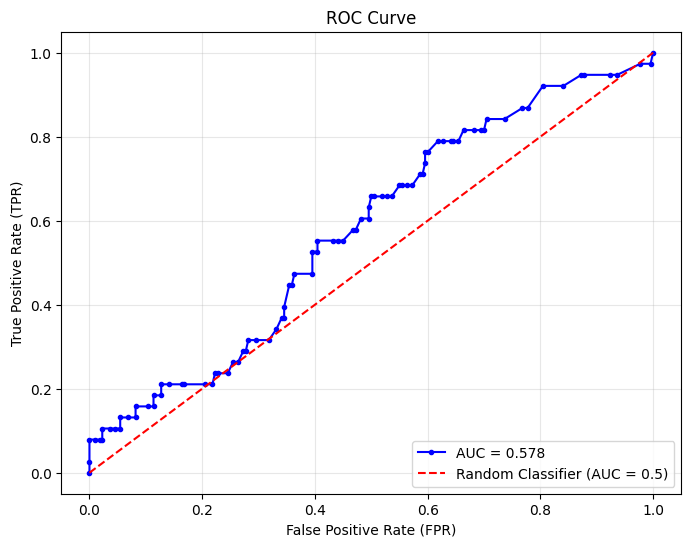

In [34]:
# Calculate FPR, TPR, and thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker = ".", color='blue', label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Save file
file_name = "plots/" + str(time.time()) + ".png"
plt.savefig(file_name)

plt.show()

In [ ]:
# Save the model (optional)
import joblib
joblib.dump(model, "decision_tree_model.pkl")

From the MSE, we can see that the error is small, a good sign. However the Regression value is very small and doesnt show much clarification. Increasing radius to 3 reduces the R2 score, but increasing the nbits representation of the fingerprints increased it. 